<a href="https://colab.research.google.com/github/rknayak/NNPytorch/blob/main/dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.optim as optim

In [18]:
n_points = 50

In [19]:
signal_center = [0.6,0.3]
signal_std = [[0.18,0.03],[0.03,0.28]]

signal_points = np.random.multivariate_normal(mean=signal_center,cov=signal_std,size=n_points)


test_signal_points = np.random.multivariate_normal(mean=signal_center,cov=signal_std,size=n_points)

In [20]:
bkg_points = np.random.rand(n_points,2)

bkg_points[:,0] = -1+2.0*bkg_points[:,0]
bkg_points[:,1] = -1+2.0*bkg_points[:,1]

test_bkg_points = np.random.rand(n_points,2)

test_bkg_points[:,0] = -1+2.0*test_bkg_points[:,0]
test_bkg_points[:,1] = -1+2.0*test_bkg_points[:,1]

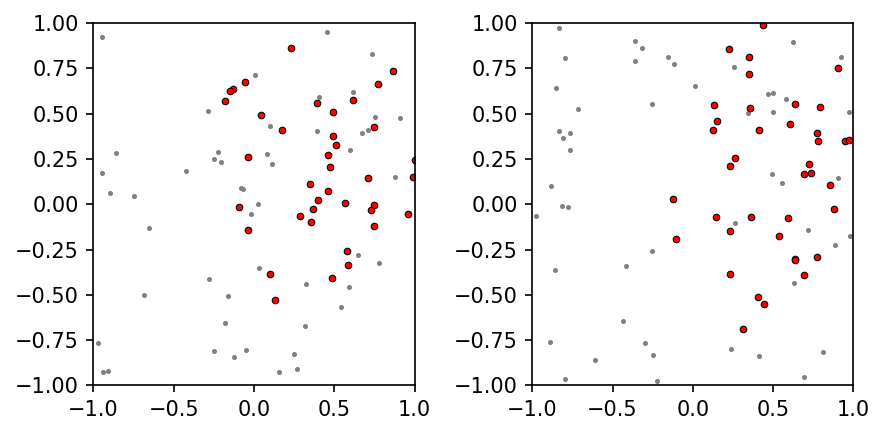

In [21]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].scatter(bkg_points[:,0],bkg_points[:,1],s=2,c='gray')
ax[0].scatter(signal_points[:,0],signal_points[:,1],s=10,c='red',ec='k',linewidth=0.5)
ax[0].set_xlim(-1,1)
ax[0].set_ylim(-1,1)


ax[1].scatter(test_bkg_points[:,0],test_bkg_points[:,1],s=2,c='gray')
ax[1].scatter(test_signal_points[:,0],test_signal_points[:,1],s=10,c='red',ec='k',linewidth=0.5)
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)

plt.tight_layout()
plt.show()

In [22]:
X = torch.FloatTensor( np.concatenate((signal_points,bkg_points)) )
Y = torch.FloatTensor( np.concatenate( ( np.ones(len(signal_points)), np.zeros(len(bkg_points)) )) ).unsqueeze(1)

dataset = TensorDataset(X, Y)


In [23]:
X_test = torch.FloatTensor( np.concatenate((test_signal_points,test_bkg_points)) )
Y_test = torch.FloatTensor( np.concatenate( ( np.ones(len(test_signal_points)),
                                             np.zeros(len(test_bkg_points)) )) ).unsqueeze(1)


In [24]:
dataloader = DataLoader(dataset,batch_size=100)

In [25]:
dropout = nn.Dropout(0.3)

In [26]:
dropout.train()

Dropout(p=0.3, inplace=False)

In [27]:
dropout.eval()

Dropout(p=0.3, inplace=False)

In [28]:
x = torch.FloatTensor(np.random.rand(10))

In [29]:
print(x)
print(dropout(x))

tensor([0.9622, 0.3749, 0.2857, 0.8686, 0.2236, 0.9632, 0.0122, 0.9699, 0.0432,
        0.8911])
tensor([0.9622, 0.3749, 0.2857, 0.8686, 0.2236, 0.9632, 0.0122, 0.9699, 0.0432,
        0.8911])


In [30]:
class Net(nn.Module):
    def __init__(self,layer_sizes,dropout_p=-1):
        super(Net,self).__init__()
        
        self.dropout_p = dropout_p
        self.layers = nn.ModuleList()
        
        
        self.layer1 = nn.Linear(2,layer_sizes[0])
        for hidden_i in range(1,len(layer_sizes)):
            self.layers.append(nn.Linear(layer_sizes[hidden_i-1],layer_sizes[hidden_i]))
        self.layer2 = nn.Linear(layer_sizes[-1],1)
        self.activation = nn.ReLU()
        if self.dropout_p > 0: 
            self.dropout = nn.Dropout(dropout_p)
    
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation(out)
        if self.dropout_p > 0: 
            out = self.dropout(out)
        for layer in self.layers:
            out = layer(out)
            out = self.activation(out)
            if self.dropout_p > 0: 
                out = self.dropout(out)
        out =   self.layer2(out) 
        return out

In [31]:
net = Net([220]*15)
netwithdrop = Net([220]*15,0.3)

In [32]:
loss_func = nn.BCEWithLogitsLoss()

In [33]:
optimizer = optim.Adam(net.parameters(), lr=1.2*1e-4)
optimizer2 = optim.Adam(netwithdrop.parameters(), lr=1.2*1e-4) 

In [34]:
from tqdm.notebook import tqdm


def train_one_epoch(nn,optimizer):
    batch_losses = []
    nn.train()
    for x,y in dataloader:
        optimizer.zero_grad()
        
        output = nn(x)
        loss = loss_func(output,y)
        
        batch_losses.append(loss.item())
        
        loss.backward()  
        optimizer.step()
    return np.mean(batch_losses)

def validation_loss(nn):
    nn.eval()
    out = nn(X_test)
    loss = loss_func(out,Y_test)
    return loss.item()
    
n_epochs = 500

loss_vs_epoch = []

for epoch in tqdm( range(n_epochs) ):

    loss_vs_epoch.append([train_one_epoch(net,optimizer),validation_loss(net)
                          ,train_one_epoch(netwithdrop,optimizer2),validation_loss(netwithdrop)] )

  0%|          | 0/500 [00:00<?, ?it/s]

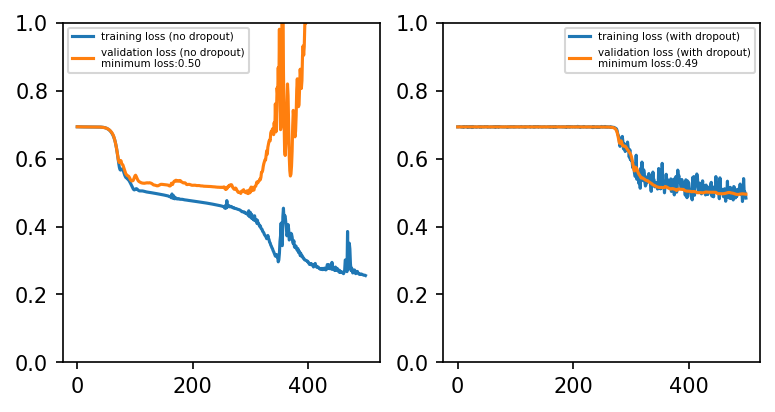

In [35]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)


loss_vs_epoch = np.array(loss_vs_epoch)

ax[0].plot(loss_vs_epoch[:,0],label='training loss (no dropout)')
ax[1].plot(loss_vs_epoch[:,2],label='training loss (with dropout)')

val_min = np.amin(loss_vs_epoch[:,1])
ax[0].plot(loss_vs_epoch[:,1],label='validation loss (no dropout)\nminimum loss:{0:.2f}'.format(val_min))
val_min = np.amin(loss_vs_epoch[:,3])
ax[1].plot(loss_vs_epoch[:,3],label='validation loss (with dropout)\nminimum loss:{0:.2f}'.format(val_min))

for i in range(2):
    ax[i].legend(fontsize=5)
    ax[i].set_ylim(0,1)
#plt.ylim(0,1)